## Airline Tweets: Sentiment Analysis & Simple Classification

### ISM6564

**Week05

&copy; 2023 Dr. Tim Smith


---

## Introduction

In this notebook we will analysze the sentiment from a dataset on how travelers tweeted about their airline-related feelings, scraped from Twitter in February 2015;.

In [23]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import numpy as np

# import tools to pre-process the text data
from sklearn import preprocessing

# Extracting features from text files
#   SciKit Learn includes a number of useful feature extraction classes 
#   https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text
# 
#   We will use TfidfVectorizer (which includes pre-processing, tokenization, and filtering out stop words)
from sklearn.feature_extraction.text import TfidfVectorizer

# import tools to reduce the dimensionality of the data
from sklearn.decomposition import TruncatedSVD

# import tools to split the data into training and test sets
from sklearn.model_selection import train_test_split

# import ML classifiers we will use to model the data
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

# import tools to evaluate the model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import RandomizedSearchCV

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dsata Load and Preparation

In [25]:
# read in the data 
df = pd.read_csv('./data/A_tweets.csv') 
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [26]:
tokenizer = TweetTokenizer()

def clear_text(text):
    # tokenize the text
    # nltk.download('punkt') # uncomment if you need to download the punkt package
    tokens = tokenizer.tokenize(text)
    
    # remove all tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    
    # make lowercase
    tokens = [word.lower() for word in tokens]

    # remove all tokens that are only one character
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

df['clean_text']=df.text.apply(lambda x: clear_text(x))   
df['hashtags'] = df.text.apply(lambda text: re.findall(r"#(\w+)", text))
df['handles'] = df.text.apply(lambda text: re.findall(r"@(\w+)", text))

In [27]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text,hashtags,handles
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,[],"[VirginAmerica, dhepburn]"
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials to the experience tacky,[],[VirginAmerica]
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need to take another trip,[],[VirginAmerica]
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive to blast obnoxious entertain...,[],[VirginAmerica]
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and really big bad thing about it,[],[VirginAmerica]
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay flight for seats that have...,[],[VirginAmerica]
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),yes nearly every time fly vx this ear worm won...,[],[VirginAmerica]
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada),really missed prime opportunity for men withou...,[],[VirginAmerica]
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada),well but now do,[],[virginamerica]
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),it was amazing and arrived an hour early too g...,[],[VirginAmerica]


In [28]:
df = df[['clean_text', 'airline', 'airline_sentiment']]

In [29]:
df.isna().sum()

clean_text           0
airline              0
airline_sentiment    0
dtype: int64

In [30]:
df["airline"].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [31]:
df = pd.get_dummies(
    df, 
    prefix_sep='_', 
    dummy_na=False, 
    drop_first=False, 
    columns=['airline'], 
    dtype='int32'
)

df.head(10)

,clean_text,airline_sentiment,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
0,what said,neutral,0,0,0,0,0,1
1,plus added commercials to the experience tacky,positive,0,0,0,0,0,1
2,today must mean need to take another trip,neutral,0,0,0,0,0,1
3,really aggressive to blast obnoxious entertain...,negative,0,0,0,0,0,1
4,and really big bad thing about it,negative,0,0,0,0,0,1
5,seriously would pay flight for seats that have...,negative,0,0,0,0,0,1
6,yes nearly every time fly vx this ear worm won...,positive,0,0,0,0,0,1
7,really missed prime opportunity for men withou...,neutral,0,0,0,0,0,1
8,well but now do,positive,0,0,0,0,0,1
9,it was amazing and arrived an hour early too g...,positive,0,0,0,0,0,1


In [32]:
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: -1 if x.lower() == 'negative' else (1 if x.lower() == 'positive' else 0))

df.head(10)

,clean_text,airline_sentiment,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
0,what said,0,0,0,0,0,0,1
1,plus added commercials to the experience tacky,1,0,0,0,0,0,1
2,today must mean need to take another trip,0,0,0,0,0,0,1
3,really aggressive to blast obnoxious entertain...,-1,0,0,0,0,0,1
4,and really big bad thing about it,-1,0,0,0,0,0,1
5,seriously would pay flight for seats that have...,-1,0,0,0,0,0,1
6,yes nearly every time fly vx this ear worm won...,1,0,0,0,0,0,1
7,really missed prime opportunity for men withou...,0,0,0,0,0,0,1
8,well but now do,1,0,0,0,0,0,1
9,it was amazing and arrived an hour early too g...,1,0,0,0,0,0,1


In [33]:
X = df.drop(['airline_sentiment'], axis=1)  
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10248, 7), (4392, 7), (10248,), (4392,))

In [35]:
X_train.isna().sum(), X_test.isna().sum()

(clean_text                0
 airline_American          0
 airline_Delta             0
 airline_Southwest         0
 airline_US Airways        0
 airline_United            0
 airline_Virgin America    0
 dtype: int64,
 clean_text                0
 airline_American          0
 airline_Delta             0
 airline_Southwest         0
 airline_US Airways        0
 airline_United            0
 airline_Virgin America    0
 dtype: int64)

In [36]:
X_train.head(10)

,clean_text,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
11077,thanks made it safely,0,0,0,1,0,0
6051,am now rapids rewards member,0,0,1,0,0,0
1929,would like your baggage damage number as well ...,0,0,0,0,1,0
11690,yes can pay out of pocket that us not helping ...,0,0,0,1,0,0
4236,with karen and found her unhelpful and rude ca...,0,0,0,0,1,0
8682,think need selfie as proof,0,1,0,0,0,0
191,trying to book flight with you guys and your w...,0,0,0,0,0,1
2881,after several trials and several hours of wait...,0,0,0,0,1,0
6104,looks like on february we will open our schedu...,0,0,1,0,0,0
3776,raise dispute with your cc provider and they w...,0,0,0,0,1,0


In [37]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X_train['clean_text'])

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print(tfidf_df.isna().sum())

tfidf_df.head(10)

aa            0
aaaand        0
aadv          0
aadvantage    0
aaron         0
             ..
zone          0
zones         0
zoom          0
zukes         0
zurich        0
Length: 8194, dtype: int64


,aa,aaaand,aadv,aadvantage,aaron,ab,aback,abandonment,abassinet,abbreve,...,zabsonre,zcc,zero,zip,zippers,zone,zones,zoom,zukes,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_train.shape, tfidf_df.shape

((10248, 7), (10248, 8194))

In [39]:
X_train = X_train.reset_index(drop=True) # need to do this, since X_train and tfidf_df have different indices

X_train = pd.concat([X_train, tfidf_df], axis=1)

X_train.isna().sum()

clean_text            0
airline_American      0
airline_Delta         0
airline_Southwest     0
airline_US Airways    0
                     ..
zone                  0
zones                 0
zoom                  0
zukes                 0
zurich                0
Length: 8201, dtype: int64

In [40]:
X_train = X_train.drop('clean_text',axis=1)

X_train.head(10)

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,aa,aaaand,aadv,aadvantage,...,zabsonre,zcc,zero,zip,zippers,zone,zones,zoom,zukes,zurich
0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,1,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_train.isna().sum()

airline_American      0
airline_Delta         0
airline_Southwest     0
airline_US Airways    0
airline_United        0
                     ..
zone                  0
zones                 0
zoom                  0
zukes                 0
zurich                0
Length: 8200, dtype: int64

In [42]:
tfidf = vectorizer.transform(X_test['clean_text'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())

X_test = X_test.reset_index(drop=True) # need to do this, since X_train and tfidf_df have different indices
X_test = pd.concat([X_test, tfidf_df], axis=1)
X_test = X_test.drop('clean_text',axis=1)

X_test.head(10)

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,aa,aaaand,aadv,aadvantage,...,zabsonre,zcc,zero,zip,zippers,zone,zones,zoom,zukes,zurich
0,1,0,0,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0.256364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,1,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,1,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0,0,1,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,1,0,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0,0,0,0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
X_train.isna().sum()

airline_American      0
airline_Delta         0
airline_Southwest     0
airline_US Airways    0
airline_United        0
                     ..
zone                  0
zones                 0
zoom                  0
zukes                 0
zurich                0
Length: 8200, dtype: int64

In [44]:
X_test.shape, X_train.shape

((4392, 8200), (10248, 8200))

## Create a Reduced Dimensions Dataset

User singular value decomposition (SVD) to create a reduced dimension dataset.

In [45]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [46]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

In [47]:
svd = TruncatedSVD(n_components=500, n_iter=10) #n_components is the number of topics, which should be less than the number of features, and number of rows in the matrix

X_train_dim_reduct = svd.fit_transform(X_train)
X_test_dim_reduct = svd.transform(X_test)

In [48]:
X_train_dim_reduct.shape, X_test_dim_reduct.shape

((10248, 500), (4392, 500))

In [49]:
## Fit RandomForrestClassifier using the dimension reduced training data

In [50]:
%%time

rf_clf = RandomForestClassifier(n_estimators=2000, max_leaf_nodes=50, n_jobs=-1).fit(X_train_dim_reduct, y_train)

CPU times: total: 15min 24s
Wall time: 1min 1s


In [51]:
%time

y_train_pred = rf_clf.predict(X_train_dim_reduct)
y_test_pred = rf_clf.predict(X_test_dim_reduct)

CPU times: total: 0 ns
Wall time: 0 ns


In [52]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.6775
Test accuracy: 0.6644


In [53]:
confusion_matrix(y_test, y_test_pred)

array([[2745,   14,    0],
       [ 806,   94,    6],
       [ 619,   29,   79]], dtype=int64)

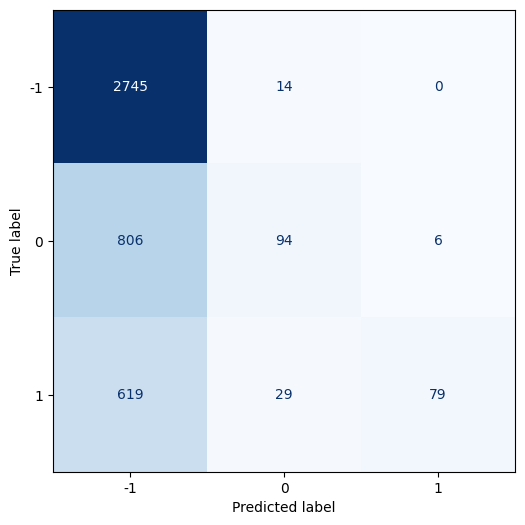

In [54]:
# display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_, colorbar=False)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=[-1,0,1], ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()

In [55]:
c_matrix = confusion_matrix(y_test, y_test_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Random Forest dim reduced", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.87037,0.104444,0.186508


## Fit RandomForrestClassifier using the original training data

In [56]:
%%time

rf_clf = RandomForestClassifier(n_estimators=2000, max_leaf_nodes=50, n_jobs=-1).fit(X_train, y_train)

CPU times: total: 5min 10s
Wall time: 22.9 s


In [57]:
%time

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.6581
Test accuracy: 0.6582


In [59]:
confusion_matrix(y_test, y_test_pred)

array([[2752,    7,    0],
       [ 855,   45,    6],
       [ 628,    5,   94]], dtype=int64)

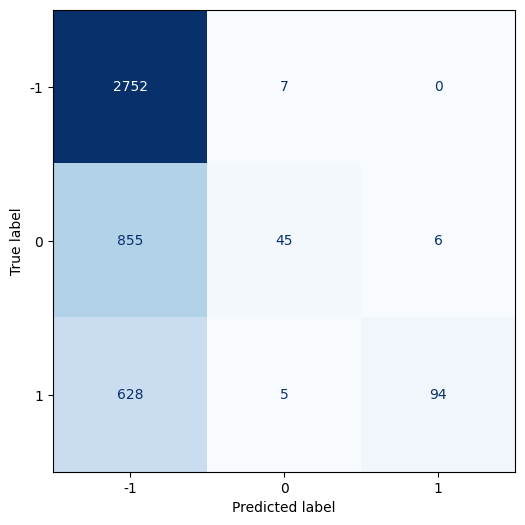

In [60]:
# display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_, colorbar=False)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=[-1,0,1], ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()

In [61]:
c_matrix = confusion_matrix(y_test, y_test_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Random Forest", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,Random Forest,0.764417,0.865385,0.050000,0.094538


## Fit RandomForrestClassifier using the dimension reduced training data and Hyperparameter Tuning

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop =30, num = 10)]
# Number of features to consider at every split
max_features = [len(X_train.columns), len(X_train.columns)//2, len(X_train.columns)//5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 10, 
    cv = 3, 
    verbose=1, 
    random_state=42, 
    n_jobs = -1)

_ = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [63]:
rf_random.best_params_

{'n_estimators': 21,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 1640,
 'max_depth': None,
 'bootstrap': False}

In [64]:
y_train_pred = rf_random.best_estimator_.predict(X_train)
y_test_pred = rf_random.best_estimator_.predict(X_test)

In [65]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.9859
Test accuracy: 0.7436


In [66]:
confusion_matrix(y_test, y_test_pred)

array([[2491,  173,   95],
       [ 444,  384,   78],
       [ 212,  124,  391]], dtype=int64)

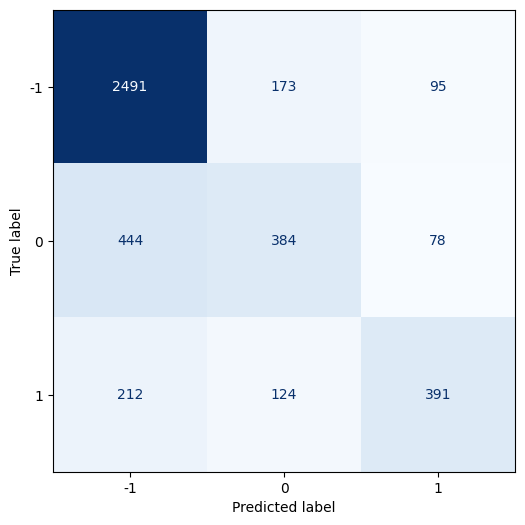

In [67]:
# display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_, colorbar=False)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=[-1,0,1], ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()

In [68]:
c_matrix = confusion_matrix(y_test, y_test_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Random Forest Random Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,Random Forest,0.764417,0.865385,0.050000,0.094538
0,Random Forest Random Search,0.823310,0.689408,0.463768,0.554513


## Logistic Regression

In [69]:
log_reg_model = LogisticRegression(penalty='none',max_iter=2000)
_ = log_reg_model.fit(X_train, np.ravel(y_train,order='C'))

c:\Users\veera\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
model_preds = log_reg_model.predict(X_test)
c_matrix = confusion_matrix(y_test, model_preds)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"default logistic", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,Random Forest,0.764417,0.865385,0.050000,0.094538
0,Random Forest Random Search,0.823310,0.689408,0.463768,0.554513
0,default logistic,0.784726,0.537129,0.559278,0.547980


## Logistic Regression with random search

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop =50, num = 10)]
# Number of features to consider at every split
max_features = [len(X_train.columns), len(X_train.columns)//2, len(X_train.columns)//5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters

lg = LogisticRegression()
lg_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 10, 
    cv = 3, 
    verbose=1, 
    random_state=42, 
    n_jobs = -1)

_ = lg_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [72]:
model_preds = lg_random.best_estimator_.predict(X_test)
c_matrix = confusion_matrix(y_test, model_preds)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"rand_search_logistic", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,Random Forest,0.764417,0.865385,0.050000,0.094538
0,Random Forest Random Search,0.823310,0.689408,0.463768,0.554513
0,default logistic,0.784726,0.537129,0.559278,0.547980
0,rand_search_logistic,0.817950,0.716738,0.395266,0.509535


## Logistic with dimension reduction

In [73]:
log_reg_model = LogisticRegression(penalty='none',max_iter=2000)
_ = log_reg_model.fit(X_train_dim_reduct, np.ravel(y_train,order='C'))

In [74]:
model_preds = log_reg_model.predict(X_test_dim_reduct)
c_matrix = confusion_matrix(y_test, model_preds)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"logistic dimension reduction", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])
performance

,model,Accuracy,Precision,Recall,F1
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,Random Forest,0.764417,0.865385,0.050000,0.094538
0,Random Forest Random Search,0.823310,0.689408,0.463768,0.554513
0,default logistic,0.784726,0.537129,0.559278,0.547980
0,rand_search_logistic,0.817950,0.716738,0.395266,0.509535
0,logistic dimension reduction,0.847079,0.706553,0.601942,0.650066


In [75]:
performance.sort_values(by='Accuracy')

,model,Accuracy,Precision,Recall,F1
0,Random Forest,0.764417,0.865385,0.050000,0.094538
0,Random Forest dim reduced,0.775895,0.870370,0.104444,0.186508
0,default logistic,0.784726,0.537129,0.559278,0.547980
0,rand_search_logistic,0.817950,0.716738,0.395266,0.509535
0,Random Forest Random Search,0.823310,0.689408,0.463768,0.554513
0,logistic dimension reduction,0.847079,0.706553,0.601942,0.650066


- Summary:


As we can see from performance data frame arranged in descending order of accuracy logistic model with dimension reduction using svd is performing better than most of the models. Even with Random search in Random forest the base model of logistic is performing better.